## Compare topic vectors

Compares genres using their distribution across 100 topics generated by Latent Dirichlet Allocation.

Let's start with some basic imports.

In [32]:
import csv, random
import pandas as pd
import numpy as np
import math, sys
from collections import Counter
from scipy import spatial
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
from sklearn.manifold import MDS

### Load data

Load the genre names, and then a file of metadata about volumes, and finally the doc-topic distribution generated by lda.

In [2]:
genrenamedf = pd.read_csv('../metadata/selected_genres.tsv', sep = '\t')
genrenames = genrenamedf.loc[genrenamedf.genretype == 'primary', 'genre'].tolist()
bgenres = genrenamedf.loc[genrenamedf.genretype == 'B genre', 'genre'].tolist()
genrenames.extend(bgenres)

intersection_genres = set(genrenamedf.loc[genrenamedf.genretype == 'intersection', 'genre'].tolist())

In [3]:
meta = pd.read_csv('../metadata/genremeta.csv')
meta.head()

,docid,author,shorttitle,enumcron,firstpub,genres,subjects,allcopiesofwork,tags
0,uc1.32106002059688,NaN,Earth is the strangest planet : ten stories of...,NaN,1977,Fiction,"Science fiction, American|Science fiction, Eng...",1,"Subj: SF, Other B"
1,uc1.32106018627064,"Woodrell, Daniel",Give us a kiss : a country noir,NaN,1998,Humorous stories|Fiction,Ozark Mountains Region|Fiction|Country life,1,Humor B
2,njp.32101068608098,"Blasco Ibáñez, Vicente",Sónnica,NaN,1918,Fiction|NotFiction,NaN,5,randomA
3,uiuo.ark+=13960=t9d517v44,NaN,The rajah's heir,v.3,1890,NaN,823R137,1,randomA
4,mdp.39015031242194,"Haggard, H. Rider (Henry Rider)","Allan's wife, and other tales",NaN,1889,Adventure fiction|NotFiction|Short stories,"Quatermain, Allan (Fictitious character)|Ficti...",2,Adventure-Not-Western


In [4]:
lda = pd.read_csv('../lda/doc_topic_distribution.csv', index_col = 'docid')
lda.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
docid,,,,,,,,,,,,,,,,,,,,,
pst.000045055782,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,...,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,2.314226e-07,1.537166e-03,6.744028e-04,2.314226e-07,2.314226e-07
pst.000022189158,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,...,3.660188e-07,3.969856e-02,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07,3.660188e-07
uc1.b4951688,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.261535e-04,6.450781e-07,6.450781e-07,...,6.450781e-07,6.450781e-07,2.428684e-02,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07,6.450781e-07
nyp.33433042850168,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,5.440246e-02,1.680108e-06,6.123931e-04,1.680108e-06,1.680108e-06,...,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,1.680108e-06,2.008461e-03,1.680108e-06,1.680108e-06
uc1.$b101948,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,7.511246e-02,4.402377e-07,5.533059e-04,4.402377e-07,6.330680e-03,...,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,4.402377e-07,1.206176e-02,4.402377e-07,4.402377e-07


### Create topic vectors 

for each genre. 

This would be very simple except that we want to be able to ensure non-overlapping comparisons, to prove that the comparison of social and textual similarity isn't circular. That's the reason for the cumbersome "exception" and "supplement" mechanics below.

Basically, the effect is to create a dictionary, ```topic_vectors,``` where the top level of keys is a genre (```g1```), and the next level of keys is the genre-to-which-it-is-to-be-compared (```g2```)! The value stored there is a topic vector summed over appropriate examples of ```g1```. For instance, if ```g1``` is "Historical fiction" and ```g2``` is "Psychological fiction," ```topic_vectors[g1][g2]``` will contain a topic vector summed over examples of historical fiction that are *not* also tagged psychological.

In [5]:
errors = set()

def has_genre(row, genre):
    tag = row.tags
    if pd.isnull(tag):
        return None
    
    tags = tag.split('|')
    if genre in tags:
        return row.docid
    else:
        return None
    
def sum_genre_except(meta, thisgenre, notthisgenre, lda):
    ''' Sums volumes that have thisgenre but 
    not notthisgenre.
    '''
    global errors
    thesedocs = meta.apply(has_genre, args = ([thisgenre]), axis = 1)
    
    if notthisgenre == 'self':
        notthesedocs = set()
    else:
        notthesedocs = meta.apply(has_genre, args = ([notthisgenre]), axis = 1)
    
    supplement_name = thisgenre + '-Not-' + notthisgenre
    supplementdocs = meta.apply(has_genre, args = ([supplement_name]), axis = 1)
    
    difference = set(thesedocs) - set(notthesedocs)
    genredocs = difference.union(set(supplementdocs))
    genredocs.remove(None)
    
    vector = np.zeros(100)
    count = 0
    for g in genredocs:
        if g in lda.index:
            vector = vector + lda.loc[g, : ]
            count += 1
        else:
            errors.add(g)
            
    if count > 0:
        return vector / count
    else:
        print('zero count', len(errors), len(genredocs))
        return float('nan')

topic_vectors = dict()

for g1 in genrenames:
    print(g1)
    topic_vectors[g1] = dict()
    for g2 in genrenames:
        intersected = g1 + '-Not-' + g2
        
        if g1 == g2:
            g2 = 'self'
        elif intersected not in intersection_genres:
            continue
            
        if g2.endswith(' B'):
            continue
        tvec = sum_genre_except(meta, g1, g2, lda)
        if np.isnan(np.sum(tvec)):
            print('error', g1, g2)
        topic_vectors[g1][g2] = tvec


Subj: Man-woman
Subj: SF, Other
Biographical
Suspense
Fantasy
Adventure
Humor
SF
Historical
Subj: Detective
Domestic
Horror
Christian
Juvenile
Western
Subj: Juvenile
Political
Short stories
Bildungsroman
Love
Subj: Horror
War
Mystery
Novel
Psychological
Subj: Humor
Subj: Fairy tales
Subj: Short stories, American
Subj: History
Subj: Short stories, Other
Subj: SF, American
Subj: Fantasy
randomA
randomB
Humor B
Subj: SF, American B
Subj: Short stories, American B
Subj: Humor B
Novel B
SF B
Short stories B
Subj: Fantasy B
Juvenile B
Fantasy B
Bildungsroman B
Historical B
Subj: Fairy tales B
Subj: Detective B
Domestic B
Mystery B
Subj: Horror B
Subj: SF, Other B
Subj: Short stories, Other B
Subj: Man-woman B
Love B
Subj: History B
Suspense B
Subj: Juvenile B
Psychological B


### Cosine distances on the vectors, without genre overlap

We're going to calculate cosine distances in two ways:

1. Vectors where genres are allowed to overlap. I.e., members of g1 can also be members of g2.

2. Vectors where g2 is excluded from g1 when the two are being compared.

We'll start with the latter.

Note that some genres have no intersection in our dataset. In this case, both genres can be compared to the raw topic vector for g1, where g2 has the value 'self.'

In [14]:
sansoverlaps = dict()

for g1 in genrenames:
    if g1.startswith('random') or g1.endswith(' B'):
        continue
        
        # We don't have social ground truth about the random sets
        # and the B genres are only there as self-comparisons, not in
        # their own right.
        
    sansoverlaps[g1] = dict()
    
    for g2 in genrenames:
        intersected = g1 + '-Not-' + g2
        
        if g2.startswith('random') or g2.endswith(' B'):
            continue
        elif g1 == g2:
            actualg2 = g1 + ' B'
            if actualg2 not in genrenames:
                sansoverlaps[g1][g2] = float('nan')
                continue
            else:
                selfcomparison = spatial.distance.cosine(topic_vectors[g1]['self'], topic_vectors[actualg2]['self'])
                sansoverlaps[g1][g2] = selfcomparison
        
        elif intersected not in intersection_genres:
            straightforward = spatial.distance.cosine(topic_vectors[g1]['self'], topic_vectors[g2]['self'])
            sansoverlaps[g1][g2] = straightforward
        
        else:
            sansoverlaps[g1][g2] = spatial.distance.cosine(topic_vectors[g1][g2], topic_vectors[g2][g1])


#### make that a dataframe

In [15]:
sansmatrix = pd.DataFrame(sansoverlaps)
sansmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,0.242510,0.264075,0.269559,0.288468,0.236151,0.211755,0.137807,0.235557,0.554802,...,0.458997,0.490340,0.293141,0.353699,0.404589,0.207870,0.337010,0.115638,0.229229,0.397866
Bildungsroman,0.242510,0.018266,0.244011,0.214107,0.023559,0.395861,0.251382,0.218844,0.129672,0.574530,...,0.463543,0.481658,0.083532,0.517385,0.603264,0.056788,0.234800,0.263806,0.425919,0.522048
Biographical,0.264075,0.244011,NaN,0.162681,0.313741,0.151726,0.032452,0.269831,0.326728,0.437317,...,0.457251,0.414279,0.270289,0.498245,0.550649,0.236074,0.164126,0.424048,0.287602,0.443693
Christian,0.269559,0.214107,0.162681,NaN,0.292262,0.278193,0.123627,0.264677,0.255881,0.411899,...,0.431184,0.414697,0.158216,0.549132,0.591069,0.238174,0.356537,0.305192,0.389795,0.482500
Domestic,0.288468,0.023559,0.313741,0.292262,0.011518,0.472698,0.319074,0.274015,0.141512,0.716054,...,0.575584,0.584091,0.107064,0.548539,0.636083,0.109499,0.287097,0.227193,0.473333,0.554101
Fantasy,0.236151,0.395861,0.151726,0.278193,0.472698,0.008561,0.133928,0.132113,0.442504,0.569797,...,0.607950,0.527034,0.411482,0.333588,0.383953,0.351549,0.387953,0.412226,0.383082,0.405356
Historical,0.211755,0.251382,0.032452,0.123627,0.319074,0.133928,0.021335,0.234327,0.350106,0.354764,...,0.425803,0.330589,0.270950,0.482939,0.526918,0.213276,0.214752,0.364295,0.258828,0.293159
Horror,0.137807,0.218844,0.269831,0.264677,0.274015,0.132113,0.234327,NaN,0.238026,0.614025,...,0.526124,0.575462,0.225115,0.345467,0.402339,0.204503,0.344361,0.220743,0.381992,0.458642
Humor,0.235557,0.129672,0.326728,0.255881,0.141512,0.442504,0.350106,0.238026,0.007469,0.679743,...,0.362184,0.634977,0.093717,0.504867,0.575267,0.192149,0.319037,0.209047,0.474752,0.611160
Juvenile,0.554802,0.574530,0.437317,0.411899,0.716054,0.569797,0.354764,0.614025,0.679743,0.047641,...,0.285322,0.063083,0.580487,0.765662,0.744469,0.442398,0.449006,0.784038,0.393613,0.494705


### Compare topic distances to social proximities

We calculated pointwise mutual information for genre labels back in ```../select_data/build_genre_dataset.ipynb.``` Now we can compare those values to our topic distances.

In [20]:
social = pd.read_csv('../socialmeasures/pmidf.csv', index_col = 'index')

In [24]:
def compare_to_social(socialdf, otherdf, use_self = False):
    ''' Compares two DataFrames, ignoring cells as instructed,
    and exporting the results in two vectors for correlation.
    '''

    socialvals = []
    othervals = []

    for idx1 in socialdf.index:
        for idx2 in socialdf.index:
            if idx1 not in otherdf.index or idx2 not in otherdf.index:
                continue
                
            otherval = otherdf.loc[idx1, idx2]
            if pd.isnull(otherval):
                continue
            elif not use_self and idx1 == idx2:
                continue
            else:
                sval = socialdf.loc[idx1, idx2]
                socialvals.append(sval)
                othervals.append(otherval)
                
    return socialvals, othervals

socialvals, topicvals = compare_to_social(social, sansmatrix, use_self = False)
print(pearsonr(socialvals, topicvals), "n = " + str(len(topicvals)))

(-0.33661622873030217, 1.0482027788758801e-27) n = 992


Medium-strong correlation. What does it look like?

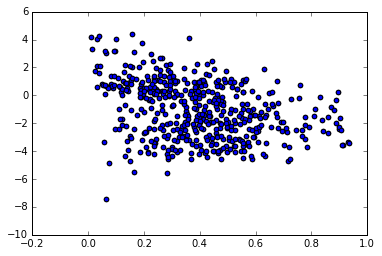

In [25]:
plt.scatter(topicvals, socialvals)
plt.show()

In [33]:
def bootstrap(vec1, vec2):
    assert len(vec1) == len(vec2)
    n = len(vec1)
    indices = []
    for i in range(n):
        indices.append(random.randrange(n))
    bs1 = [vec1[x] for x in indices]
    bs2 = [vec2[x] for x in indices]
    return bs1, bs2

def boot_sample(vec1, vec2):
    corrs = []
    for i in range(10000):
        bs1, bs2 = bootstrap(vec1, vec2)
        r = pearsonr(bs1, bs2)
        corrs.append(r[0])
    corrs.sort()
    return corrs

uncertainty = boot_sample(topicvals, socialvals)
print(uncertainty[500], uncertainty[9500])

-0.383979869371 -0.287883322195


In [34]:
with open('../results/bootstrapped_topicsans_r.txt', mode = 'w', encoding = 'utf-8') as f:
    for u in uncertainty:
        f.write(str(u) + '\n')

### Visualize topic similarity as a 2d map

In [26]:
# NaNs are no good here

for idx in sansmatrix.index:
    sansmatrix.loc[idx, idx] = 0
    
scaler = MDS(metric = True, dissimilarity = 'precomputed')
coordinates = scaler.fit_transform(sansmatrix)

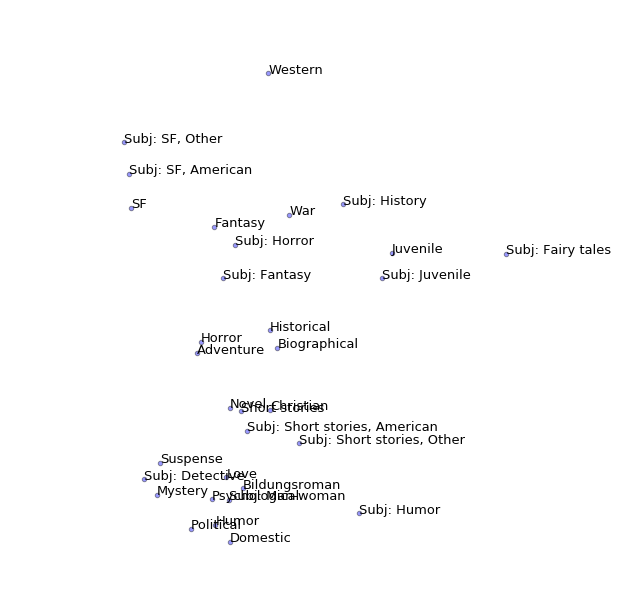

In [27]:
fig, ax = plt.subplots(figsize = (10, 10))
genres = sansmatrix.index.tolist()
colors=np.linspace(0, 1, 7)
ax.scatter(coordinates[ :, 0], coordinates[ : , 1], alpha = 0.4)
#ax.set_xlim((-0.65, 1.35))
# ax.set_ylim((-1.9, 2.1))
for i in range(len(genres)):
    thisx = coordinates[i, 0]
    thisy = coordinates[i, 1]
    name = genres[i]
    ax.annotate(name, (thisx, thisy), fontsize = 13)
plt.axis('off')
# plt.savefig('new2detectiveMDS.png', bbox_inches = 'tight')
plt.show()

### Cosine distances with genre overlap

In [28]:
withoverlaps = dict()

for g1 in genrenames:
    if g1.startswith('random') or g1.endswith(' B'):
        continue
        
        # We don't have social ground truth about the random sets
        # and the B genres are only there as self-comparisons, not in
        # their own right.
        
    withoverlaps[g1] = dict()
    
    for g2 in genrenames:
        
        if g2.startswith('random') or g2.endswith(' B'):
            continue
        elif g1 == g2:
            actualg2 = g1 + ' B'
            if actualg2 not in genrenames:
                withoverlaps[g1][g2] = float('nan')
                continue
            else:
                selfcomparison = spatial.distance.cosine(topic_vectors[g1]['self'], topic_vectors[actualg2]['self'])
                withoverlaps[g1][g2] = selfcomparison
        
        else:
            straightforward = spatial.distance.cosine(topic_vectors[g1]['self'], topic_vectors[g2]['self'])
            withoverlaps[g1][g2] = straightforward

In [29]:
withmatrix = pd.DataFrame(withoverlaps)
withmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,0.238958,0.259606,0.269559,0.279976,0.233101,0.210753,0.137807,0.235557,0.554802,...,0.458997,0.490340,0.285888,0.353699,0.404589,0.207870,0.337010,0.115638,0.221977,0.388602
Bildungsroman,0.238958,0.018266,0.244011,0.214107,0.024661,0.395861,0.251382,0.218844,0.121259,0.574530,...,0.463543,0.481658,0.080829,0.517385,0.603264,0.056788,0.234800,0.261793,0.419771,0.522048
Biographical,0.259606,0.244011,NaN,0.155190,0.313741,0.151726,0.029081,0.269831,0.326728,0.437317,...,0.457251,0.414279,0.270289,0.498245,0.550649,0.236074,0.164126,0.424048,0.279196,0.405448
Christian,0.269559,0.214107,0.155190,NaN,0.281406,0.257975,0.123627,0.264677,0.257135,0.411899,...,0.431184,0.414697,0.158216,0.549132,0.591069,0.238174,0.356537,0.305192,0.389795,0.482500
Domestic,0.279976,0.024661,0.313741,0.281406,0.011518,0.472698,0.319074,0.274015,0.141512,0.716054,...,0.575584,0.584091,0.108710,0.548539,0.636083,0.109499,0.287097,0.227193,0.471072,0.554101
Fantasy,0.233101,0.395861,0.151726,0.257975,0.472698,0.008561,0.133928,0.124591,0.442504,0.569797,...,0.607950,0.527034,0.411482,0.333588,0.383953,0.351549,0.387953,0.412226,0.377413,0.405356
Historical,0.210753,0.251382,0.029081,0.123627,0.319074,0.133928,0.021335,0.234327,0.350106,0.354764,...,0.425803,0.330589,0.267280,0.482939,0.526918,0.213276,0.214752,0.364295,0.228321,0.293159
Horror,0.137807,0.218844,0.269831,0.264677,0.274015,0.124591,0.234327,NaN,0.238026,0.614025,...,0.526124,0.575462,0.225115,0.338066,0.398726,0.204503,0.344361,0.220743,0.381992,0.448871
Humor,0.235557,0.121259,0.326728,0.257135,0.141512,0.442504,0.350106,0.238026,0.007469,0.679743,...,0.362184,0.634977,0.093717,0.504867,0.575267,0.192149,0.319037,0.209047,0.474752,0.611160
Juvenile,0.554802,0.574530,0.437317,0.411899,0.716054,0.569797,0.354764,0.614025,0.679743,0.047641,...,0.285322,0.062316,0.580487,0.765662,0.744469,0.442398,0.449006,0.784038,0.393613,0.494705


(-0.34338903725593373, 7.8059509978528434e-29) n = 992


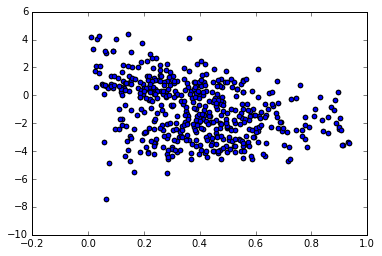

In [31]:
socialvals, withvals = compare_to_social(social, withmatrix, use_self = False)
print(pearsonr(socialvals, withvals), "n = " + str(len(withvals)))
plt.scatter(withvals, socialvals)
plt.show()

### Bootstrap results (with overlap) for uncertainty

In [36]:
uncertainty = boot_sample(socialvals, withvals)
print(uncertainty[500], uncertainty[9500])

-0.390523976141 -0.294122175647


In [37]:
with open('../results/bootstrapped_topicwith_r.txt', mode = 'w', encoding = 'utf-8') as f:
    for u in uncertainty:
        f.write(str(u) + '\n')

### Normalize the topic vectors for date

In [38]:
yearvec = dict()
yearct = Counter()

meta = pd.read_csv('../metadata/genremeta.csv')
                  
for idx, row in lda.iterrows():
    date = int(meta.loc[meta.docid == idx, 'firstpub'])
    # not really first date of publication; conventional column name
    # required by software elsewhere
    if date < 1700 or date > 2015:
        continue
        
    if date not in yearvec:
        yearvec[date] = row
    else:
        yearvec[date] = yearvec[date] + row
    
    yearct[date] += 1

print(len(yearvec)) 

211


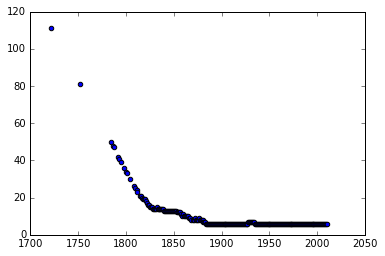

In [39]:
avgfreqs = dict()
spans = []
dates = []
for date, vec in yearvec.items():
    span = 5
    included = 0
    
    # iterate until we get a span big enough to include
    while included < 150:
        included = 0
        for yr in range(date - span, date + (span + 1)):
            included += yearct[yr]
        span += 1
    
    dates.append(date)
    spans.append(span)
    
    summedvectors = np.zeros(100)
    for yr in (date - span, date + span + 1):
        if yr in yearvec:
            summedvectors = summedvectors + yearvec[yr]
    
    avgfreqs[date] = summedvectors / (np.sum(summedvectors))
    
plt.scatter(dates, spans)
plt.show()


In [40]:
# Normalized topic vectors

errors = set()
    
def sum_genre_normalized(meta, thisgenre, notthisgenre, lda):
    ''' Sums volumes that have thisgenre but 
    not notthisgenre.
    '''
    global errors, avgfreqs
    thesedocs = meta.apply(has_genre, args = ([thisgenre]), axis = 1)
    
    if notthisgenre == 'self':
        notthesedocs = set()
    else:
        notthesedocs = meta.apply(has_genre, args = ([notthisgenre]), axis = 1)
    
    supplement_name = thisgenre + '-Not-' + notthisgenre
    supplementdocs = meta.apply(has_genre, args = ([supplement_name]), axis = 1)
    
    difference = set(thesedocs) - set(notthesedocs)
    genredocs = difference.union(set(supplementdocs))
    genredocs.remove(None)
    
    vector = np.zeros(100)
    count = 0
    for g in genredocs:
        if g in lda.index:
            thisdoc = lda.loc[g, : ]
            thisdate = int(meta.loc[meta.docid == g, 'firstpub'])
            normalized = thisdoc - avgfreqs[thisdate]
            
            vector = vector + normalized
            count += 1
        else:
            errors.add(g)
            
    if count > 0:
        return vector / count
    else:
        print('zero count', len(errors), len(genredocs))
        return float('nan')

normal_vectors = dict()

for g1 in genrenames:
    print(g1)
    normal_vectors[g1] = dict()
    for g2 in genrenames:
        intersected = g1 + '-Not-' + g2
        
        if g1 == g2:
            g2 = 'self'
        elif intersected not in intersection_genres:
            continue
            
        if g2.endswith(' B'):
            continue
        tvec = sum_genre_normalized(meta, g1, g2, lda)
        if np.isnan(np.sum(tvec)):
            print('error', g1, g2)
        normal_vectors[g1][g2] = tvec



Subj: Man-woman
Subj: SF, Other
Biographical
Suspense
Fantasy
Adventure
Humor
SF
Historical
Subj: Detective
Domestic
Horror
Christian
Juvenile
Western
Subj: Juvenile
Political
Short stories
Bildungsroman
Love
Subj: Horror
War
Mystery
Novel
Psychological
Subj: Humor
Subj: Fairy tales
Subj: Short stories, American
Subj: History
Subj: Short stories, Other
Subj: SF, American
Subj: Fantasy
randomA
randomB
Humor B
Subj: SF, American B
Subj: Short stories, American B
Subj: Humor B
Novel B
SF B
Short stories B
Subj: Fantasy B
Juvenile B
Fantasy B
Bildungsroman B
Historical B
Subj: Fairy tales B
Subj: Detective B
Domestic B
Mystery B
Subj: Horror B
Subj: SF, Other B
Subj: Short stories, Other B
Subj: Man-woman B
Love B
Subj: History B
Suspense B
Subj: Juvenile B
Psychological B


In [42]:
# cosine distances on normalized

normedsansoverlap = dict()

for g1 in genrenames:
    if g1.startswith('random') or g1.endswith(' B'):
        continue
        
        # We don't have social ground truth about the random sets
        # and the B genres are only there as self-comparisons, not in
        # their own right.
        
    normedsansoverlap[g1] = dict()
    
    for g2 in genrenames:
        intersected = g1 + '-Not-' + g2
        
        if g2.startswith('random') or g2.endswith(' B'):
            continue
        elif g1 == g2:
            actualg2 = g1 + ' B'
            if actualg2 not in genrenames:
                normedsansoverlap[g1][g2] = 0
                continue
            else:
                selfcomparison = spatial.distance.cosine(normal_vectors[g1]['self'], normal_vectors[actualg2]['self'])
                normedsansoverlap[g1][g2] = selfcomparison
        
        elif intersected not in intersection_genres:
            straightforward = spatial.distance.cosine(normal_vectors[g1]['self'], normal_vectors[g2]['self'])
            normedsansoverlap[g1][g2] = straightforward
        
        else:
            normedsansoverlap[g1][g2] = spatial.distance.cosine(normal_vectors[g1][g2], normal_vectors[g2][g1])

normedmatrix = pd.DataFrame(normedsansoverlap)
normedmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,0.000000,1.375200,1.090688,1.090474,1.390811,0.777705,0.920147,0.697203,1.248436,0.739829,...,0.953013,0.838118,1.530562,0.750576,0.743877,1.093652,1.304505,0.395394,0.535788,0.706236
Bildungsroman,1.375200,0.048870,1.182635,1.035123,0.051953,1.499181,1.328811,1.225447,0.717542,0.973088,...,0.986731,0.791740,0.516955,1.260947,1.330959,0.167676,0.850723,1.220929,1.273984,1.143728
Biographical,1.090688,1.182635,0.000000,0.677255,1.281870,0.438637,0.128014,1.125738,1.388342,0.946299,...,1.172172,0.997957,1.276834,1.203688,1.247975,1.210404,0.597149,1.514172,0.759256,0.896298
Christian,1.090474,1.035123,0.677255,0.000000,1.067635,0.829233,0.555162,1.065289,1.022057,1.091230,...,1.173385,1.156622,0.773028,1.246010,1.252488,1.243197,1.252187,0.966429,1.064673,1.019380
Domestic,1.390811,0.051953,1.281870,1.067635,0.046802,1.633304,1.374270,1.336332,0.728148,0.907194,...,1.022642,0.745287,0.489887,1.281654,1.320953,0.266229,0.889054,1.062773,1.267809,1.136656
Fantasy,0.777705,1.499181,0.438637,0.829233,1.633304,0.025287,0.334170,0.411371,1.605176,1.063099,...,1.316038,1.062125,1.539946,0.698662,0.754531,1.392158,1.168158,1.218685,0.851319,0.732397
Historical,0.920147,1.328811,0.128014,0.555162,1.374270,0.334170,0.078223,0.985111,1.607434,0.781250,...,1.219302,0.902402,1.457691,1.139786,1.183886,1.282243,0.865257,1.272549,0.670122,0.561604
Horror,0.697203,1.225447,1.125738,1.065289,1.336332,0.411371,0.985111,0.000000,1.268557,1.246406,...,1.210462,1.269474,1.181344,0.702263,0.738515,1.047292,1.316164,0.899935,1.066339,0.878808
Humor,1.248436,0.717542,1.388342,1.022057,0.728148,1.605176,1.607434,1.268557,0.046133,1.096678,...,0.389985,1.166835,0.398340,1.206830,1.189944,0.786013,1.032447,1.031904,1.337105,1.328879
Juvenile,0.739829,0.973088,0.946299,1.091230,0.907194,1.063099,0.781250,1.246406,1.096678,0.437143,...,0.897124,0.200799,1.376241,1.069515,1.074752,1.052329,1.051224,0.913928,0.390476,0.592424


(-0.38437726407210865, 2.8084985538204369e-36) n = 992


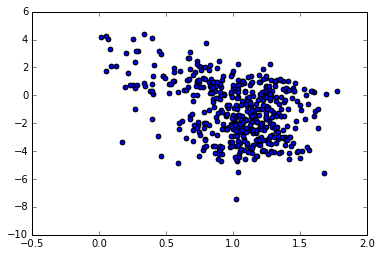

In [43]:
socialvals, normedvals = compare_to_social(social, normedmatrix, use_self = False)
print(pearsonr(socialvals, normedvals), "n = " + str(len(normedvals)))
plt.scatter(normedvals, socialvals)
plt.show()

### Interpretation

Centering the topic vectors on a running-average topic vector for the publication date before comparing them significantly improves correlation with our social ground truth.

In [44]:
uncertainty = boot_sample(socialvals, normedvals)
print(uncertainty[500], uncertainty[9500])
with open('../results/bootstrapped_topicdatenormed.txt', mode = 'w', encoding = 'utf-8') as f:
    for u in uncertainty:
        f.write(str(u) + '\n')

-0.434750918698 -0.332594442354
